In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from newsapi import NewsApiClient
from datetime import datetime, timedelta, timezone
import pytz
import openpyxl
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dropout, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from dotenv import load_dotenv
import os

In [3]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [4]:
# Load the data
# Load the data and convert 'Date' column to datetime
btc_data = pd.read_csv('D:/portfolio_projects/btc_pred_project/BTC-USD.csv', parse_dates=['Date'])

# Sort dataframe by 'Date'
btc_data = btc_data.sort_values(by='Date')


btc_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-10,27654.636719,28322.687500,26883.669922,27621.755859,27621.755859,20656025026
1,2023-05-11,27621.085938,27621.941406,26781.826172,27000.789063,27000.789063,16724343943
2,2023-05-12,26987.662109,27055.646484,25878.429688,26804.990234,26804.990234,19313599897
3,2023-05-13,26807.769531,27030.482422,26710.873047,26784.078125,26784.078125,9999171605
4,2023-05-14,26788.974609,27150.976563,26661.355469,26930.638672,26930.638672,10014858959
5,2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,14413231792
6,2023-05-16,27171.513672,27299.304688,26878.947266,27036.650391,27036.650391,12732238816
7,2023-05-17,27035.470703,27465.927734,26600.144531,27398.802734,27398.802734,15140006925
8,2023-05-18,27401.650391,27466.527344,26415.101563,26832.208984,26832.208984,15222938600
9,2023-05-19,26826.753906,27128.619141,26700.210938,26890.128906,26890.128906,11258983301


In [4]:
# Summary statistics
print(btc_data.describe())

# Check for missing values
print(btc_data.isnull().sum())

                      Date          Open          High           Low  \
count                   93     93.000000     93.000000     93.000000   
mean   2023-06-25 00:00:00  28511.128675  28896.710329  28156.613197   
min    2023-05-10 00:00:00  25121.673828  25735.308594  24797.167969   
25%    2023-06-02 00:00:00  26871.158203  27265.917969  26621.140625   
50%    2023-06-25 00:00:00  29161.812500  29353.160156  28934.294922   
75%    2023-07-18 00:00:00  30086.187500  30427.589844  29777.285156   
max    2023-08-10 00:00:00  31474.720703  31814.515625  30659.355469   
std                    NaN   1714.937352   1729.445125   1751.939793   

              Close     Adj Close        Volume  
count     93.000000     93.000000  9.300000e+01  
mean   28530.207955  28530.207955  1.395357e+10  
min    25124.675781  25124.675781  6.481776e+09  
25%    26868.353516  26868.353516  1.097279e+10  
50%    29176.916016  29176.916016  1.324016e+10  
75%    30086.246094  30086.246094  1.583738e+10  
m

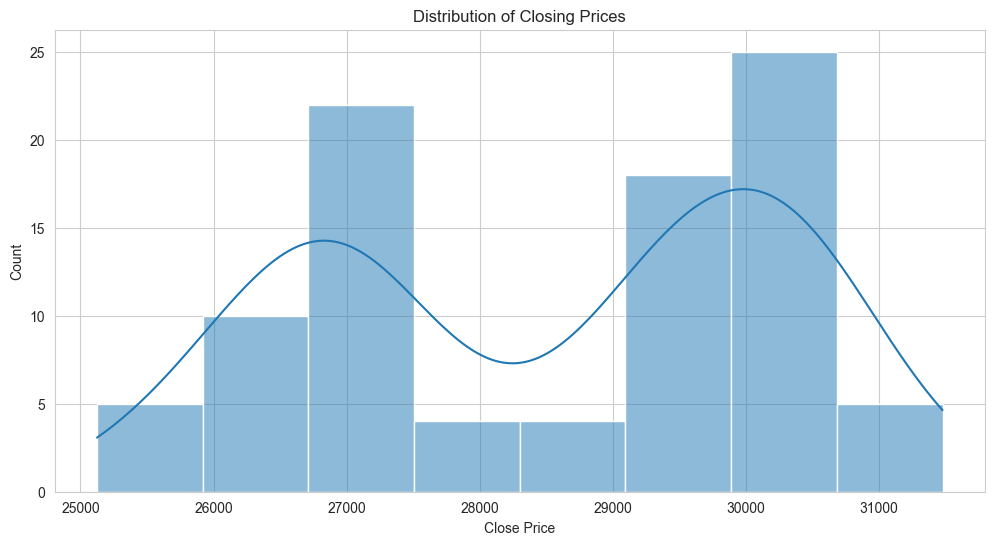

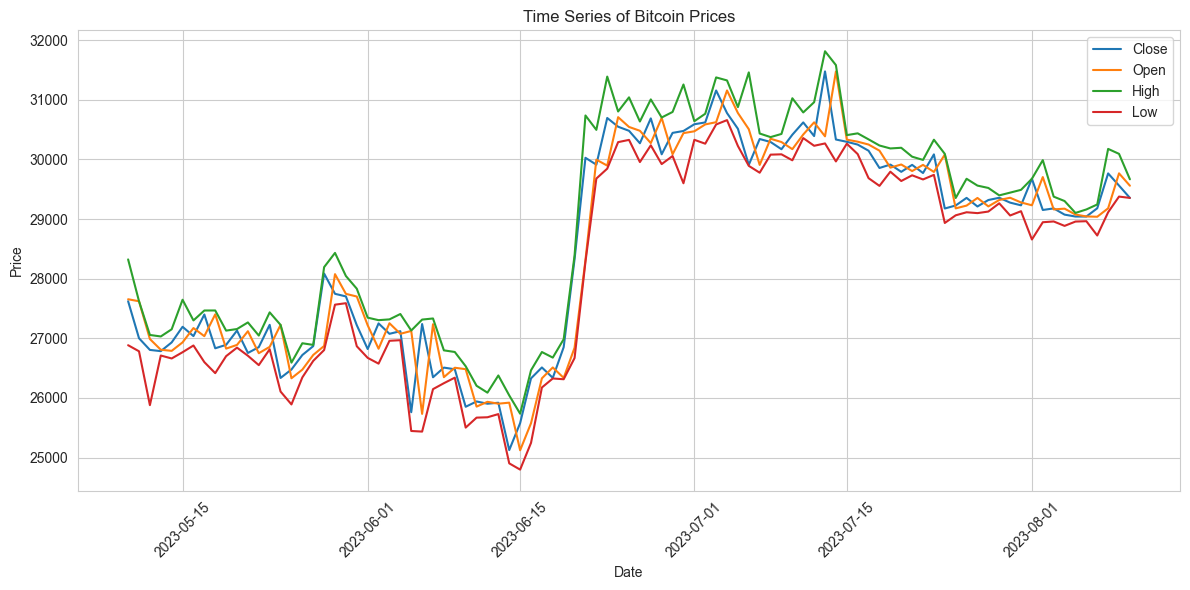

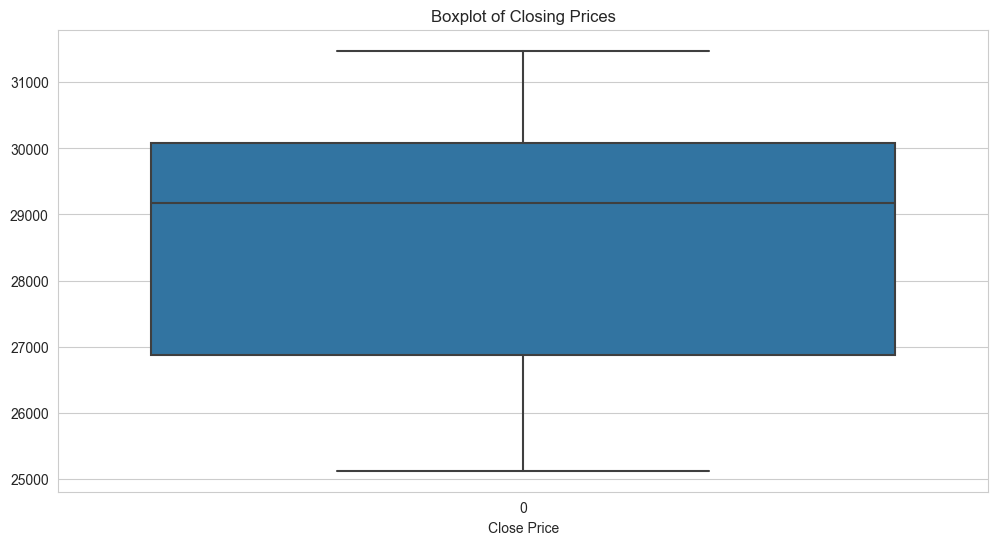

In [5]:
# Set style
sns.set_style("whitegrid")

# Distribution of Closing Prices
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Count')
plt.show()

# Time Series of Closing, Open, High, and Low Prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=btc_data, x='Date', y='Close', label='Close')
sns.lineplot(data=btc_data, x='Date', y='Open', label='Open')
sns.lineplot(data=btc_data, x='Date', y='High', label='High')
sns.lineplot(data=btc_data, x='Date', y='Low', label='Low')
plt.title('Time Series of Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Box plot to understand statistical summary of Close Price
plt.figure(figsize=(12, 6))
sns.boxplot(btc_data['Close'])
plt.title('Boxplot of Closing Prices')
plt.xlabel('Close Price')
plt.show()


In [13]:
load_dotenv()  # This will load the variables from .env
api_key = os.getenv('NEWSAPI_KEY')
newsapi = NewsApiClient(api_key=api_key)

# Define a list of reputable US sources (you can modify this list as needed)
reliable_sources = [
    'abc-news', 'bloomberg', 'business-insider', 'cbs-news', 'cnn', 
    'fox-news', 'msnbc', 'national-geographic', 'nbc-news', 'newsweek', 
    'new-york-magazine', 'reuters', 'the-huffington-post', 'the-wall-street-journal', 
    'the-washington-post', 'time', 'usa-today', 'vice-news', 'wired', 'forbes'
]

# Loop through the past 30 days
all_articles = []
for i in range(30):
    date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')

    # Make the API call for the specific date
    articles = newsapi.get_everything(q='bitcoin',
                                      from_param=date,
                                      to=date,
                                      sources=','.join(reliable_sources),
                                      language='en',
                                      sort_by='publishedAt',
                                      page_size=5)  # fetch 5 articles per day
                                      
    all_articles.extend(articles['articles'])

# Print out the articles
for article in all_articles:
    print(article['title'], "-", article['source']['name'])

US stocks finish the week mostly lower as July inflation data comes in mixed - Business Insider
US stocks drop after wholesale inflation comes in hotter than expected - Business Insider
US stocks whipsaw but close higher as Wall Street mulls Fed outlook after July CPI - Business Insider
In Decentralized Finance, Two Heads Can Be Better Than One - Newsweek
Tech tips to avoid contractor scams after a storm or disaster - Fox News
US stocks rise after CPI shows inflation came in cooler than expected in July - Business Insider
US stocks fall as investors brace for July CPI report - Business Insider
US stocks slip as investors struggle to recover from sell-off ahead of key inflation report - Business Insider
US stocks drop as bank shares slide after Moody's downgrades 10 firms - Business Insider
Here's what CEOs are saying about consumer spending - CNN
PayPal's latest crypto play is a stablecoin pegged to the US dollar - Business Insider
US stocks rise as investors digest 2nd-quarter earning

In [14]:
# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(all_articles)

# Since the 'source' column itself contains dictionaries with 'id' and 'name', 
# we can create separate columns for them
df['source_id'] = df['source'].apply(lambda x: x['id'])
df['source_name'] = df['source'].apply(lambda x: x['name'])
df = df.drop(columns=['source'])

# Display the DataFrame
print(df.head())

                                   author  \
0                             Matthew Fox   
1  mfox@businessinsider.com (Matthew Fox)   
2                               Max Adams   
3                Tommy and Taylor Johnson   
4          Kurt Knutsson, CyberGuy Report   

                                               title  \
0  US stocks finish the week mostly lower as July...   
1  US stocks drop after wholesale inflation comes...   
2  US stocks whipsaw but close higher as Wall Str...   
3  In Decentralized Finance, Two Heads Can Be Bet...   
4  Tech tips to avoid contractor scams after a st...   

                                         description  \
0  Wholesale prices for July edged up more than a...   
1  "The increase in wholesale prices serves as a ...   
2  Stocks initially rallied hard after CPI data w...   
3  For two twins looking to transform the way peo...   
4  Scammers are using natural disasters to pose a...   

                                                 url  \

In [15]:
df['publishedAt'].min()

'2023-07-17T10:27:49Z'

In [16]:
df['publishedAt'].max()

'2023-08-11T20:03:55Z'

In [17]:
# Assuming df is your DataFrame
# Convert the 'publishedAt' column to datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Convert from UTC to Eastern Daylight Time (EDT)
eastern = pytz.timezone('US/Eastern')
df['publishedAt'] = df['publishedAt'].dt.tz_convert(eastern)

# Extract the date and format it as YYYY-MM-DD
df['publishedAt'] = df['publishedAt'].dt.date

# Now the 'publishedAt' column is in the desired format
print(df.head())

                                   author  \
0                             Matthew Fox   
1  mfox@businessinsider.com (Matthew Fox)   
2                               Max Adams   
3                Tommy and Taylor Johnson   
4          Kurt Knutsson, CyberGuy Report   

                                               title  \
0  US stocks finish the week mostly lower as July...   
1  US stocks drop after wholesale inflation comes...   
2  US stocks whipsaw but close higher as Wall Str...   
3  In Decentralized Finance, Two Heads Can Be Bet...   
4  Tech tips to avoid contractor scams after a st...   

                                         description  \
0  Wholesale prices for July edged up more than a...   
1  "The increase in wholesale prices serves as a ...   
2  Stocks initially rallied hard after CPI data w...   
3  For two twins looking to transform the way peo...   
4  Scammers are using natural disasters to pose a...   

                                                 url  \

In [18]:
df['publishedAt'].min()

datetime.date(2023, 7, 17)

In [19]:
df['publishedAt'].max()

datetime.date(2023, 8, 11)

In [5]:
btc_trunc = btc_data[ (btc_data['Date'] >= '2023-7-12') & (btc_data['Date'] <= '2023-8-9')]
btc_trunc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
63,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717
64,2023-07-13,30387.488281,31814.515625,30268.351563,31476.048828,31476.048828,23686079548
65,2023-07-14,31474.720703,31582.253906,29966.386719,30334.068359,30334.068359,20917902660
66,2023-07-15,30331.783203,30407.781250,30263.462891,30295.806641,30295.806641,8011667756
67,2023-07-16,30297.472656,30437.560547,30089.669922,30249.132813,30249.132813,8516564470


In [21]:
btc_trunc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [22]:
df.dtypes

author         object
title          object
description    object
url            object
urlToImage     object
publishedAt    object
content        object
source_id      object
source_name    object
dtype: object

In [24]:
# Convert the 'publishedAt' column in df to string format
df['publishedAt'] = df['publishedAt'].astype(str)
btc_trunc.loc[:, 'Date'] = btc_trunc['Date'].astype(str)

# Perform the left join
merged_df = btc_trunc.merge(df, left_on='Date', right_on='publishedAt', how='left')

# Check the result
merged_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,author,title,description,url,urlToImage,publishedAt,content,source_id,source_name
0,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-13,30387.488281,31814.515625,30268.351563,31476.048828,31476.048828,23686079548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-14,31474.720703,31582.253906,29966.386719,30334.068359,30334.068359,20917902660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-07-15,30331.783203,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-07-16,30297.472656,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Drop the 'publishedAt' column
merged_df.drop(columns=['publishedAt'], inplace=True)

# Convert the 'Date' column back to datetime object
merged_df['Date'] = pd.to_datetime(merged_df['Date'])




In [ ]:
# Save the resulting DataFrame to an Excel file
#merged_df.to_excel('merged_df.xlsx', index=False)

In [6]:
### START FROM HERE


merged_df = pd.read_excel('merged_df.xlsx', engine='openpyxl')

In [7]:
print(merged_df.dtypes)
print(merged_df.head(3))


Date           datetime64[ns]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj Close             float64
Volume                  int64
author                 object
title                  object
description            object
url                    object
urlToImage             object
content                object
source_id              object
source_name            object
dtype: object
        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
2 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   

      Adj Close       Volume                          author  \
0  30391.646484  14805659717                    Jennifer Sor   
1  30391.646484  14805659717  Kurt Knutsson, CyberGuy Report   
2  30391.646484  14805659717                    Jennife

In [29]:
merged_df['description'].head(10)

0    Bets that the Federal Reserve will pause rate ...
1    Smartphones have a feature that allows you to ...
2    Inflation dropped to 3% in June, marking the l...
3    Recently, the Russian embassy in Kenya said th...
4    Crypto-linked stocks like Coinbase and Riot Bl...
5    The producer price index for June climbed 0.1%...
6    Central America is experiencing a wave of unre...
7    Earnings results from JPMorgan, Wells Fargo, a...
8    Alex Mashinsky, the former CEO of collapsed cr...
9    Federal officials this week charged Andrew Ven...
Name: description, dtype: object

In [30]:
len(merged_df['source_name'].unique())

13

In [31]:
merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,author,title,description,url,urlToImage,content,source_id,source_name
0,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717,Jennifer Sor,US stocks climb as traders hope cooler June in...,Bets that the Federal Reserve will pause rate ...,https://markets.businessinsider.com/news/stock...,https://i.insider.com/5eb59db41441927acb5792f6...,Getty Images / Bryan R. Smith\r\n<ul>\n<li>US ...,business-insider,Business Insider
1,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717,"Kurt Knutsson, CyberGuy Report",This quick trick lets you copy text from any i...,Smartphones have a feature that allows you to ...,https://www.foxnews.com/tech/quick-trick-copy-...,https://static.foxnews.com/foxnews.com/content...,Have you ever captured a photo of a sign or po...,fox-news,Fox News
2,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717,Jennifer Sor,US stocks jump as investors cheer lowest infla...,"Inflation dropped to 3% in June, marking the l...",https://markets.businessinsider.com/news/stock...,https://i.insider.com/5a87472ed03072fc098b47fc...,JOHANNES EISELE/Getty Images\r\n<ul>\n<li>Head...,business-insider,Business Insider
3,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,30391.646484,14805659717,ztayeb@businessinsider.com (Zahra Tayeb),'Rich Dad Poor Dad' author Robert Kiyosaki war...,"Recently, the Russian embassy in Kenya said th...",https://markets.businessinsider.com/news/stock...,https://i.insider.com/645b44a8c726bc00196aad14...,"""Rich Dad Poor Dad"" author Robert Kiyosaki iss...",business-insider,Business Insider
4,2023-07-13,30387.488281,31814.515625,30268.351563,31476.048828,31476.048828,23686079548,mfox@businessinsider.com (Matthew Fox),XRP soars 61% after a judge says the cryptocur...,Crypto-linked stocks like Coinbase and Riot Bl...,https://markets.businessinsider.com/news/commo...,https://i.insider.com/64b02d51c22d1a0019454eba...,XRP soared as much as 61% on Thursday after a ...,business-insider,Business Insider


In [8]:
# Dropping unnecessary columns
dfx = merged_df.drop(['Adj Close', 'url', 'urlToImage', 'source_id', 'author'], axis=1)

# Drop rows containing NaN values in 'title', 'description', and 'content' columns
dfx.dropna(subset=['title', 'description', 'content'], inplace=True)

# Grouping by Date and aggregating the required columns
grouped_df = dfx.groupby('Date').agg({
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Close': 'mean',
    'Volume': 'mean',
    'title': lambda x: ' '.join(x),
    'description': lambda x: ' '.join(x),
    'content': lambda x: ' '.join(x),
}).reset_index()

# Adding source name counts
source_counts = dfx.groupby(['Date', 'source_name']).size().unstack(fill_value=0).reset_index()
final_df = pd.merge(grouped_df, source_counts, how='left', on='Date')

# Resulting DataFrame
print(final_df.head())


        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

         Volume                                              title  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur...   
2  2.091790e+10  A wave of political turbulence is rolling thro...   
3  1.324016e+10  US stocks rally as recession fears ease and in...   
4  1.313890e+10  Dow extends winning streak to 7 days as US sto...   

                                         description  \
0  Bets that the Federal Reserve will pause rate ...   
1  Crypto-linked stocks like Coinb

In [9]:
final_df['Date'].max()

Timestamp('2023-08-09 00:00:00')

In [10]:
# Selecting only the numeric columns (excluding the target 'Close')
df_num = final_df[['Close','Open','High','Low','Date','Volume'] + [col for col in final_df.columns if final_df[col].dtype == 'int64']]
df_num.head(10)

,Close,Open,High,Low,Date,Volume,ABC News,Business Insider,CNN,Fox News,NBC News,New York Magazine,Newsweek,Reuters,The Washington Post,Time,USA Today,Wired
0,30391.646484,30622.246094,30959.964844,30228.835938,2023-07-12,1.480566e+10,0,3,0,1,0,0,0,0,0,0,0,0
1,31476.048828,30387.488281,31814.515625,30268.351563,2023-07-13,2.368608e+10,0,2,0,0,0,0,0,0,0,0,0,0
2,30334.068359,31474.720703,31582.253906,29966.386719,2023-07-14,2.091790e+10,1,1,1,1,0,0,0,0,0,0,0,1
3,30145.888672,30249.626953,30336.400391,29685.783203,2023-07-17,1.324016e+10,0,3,0,0,0,0,0,0,0,0,0,0
4,29856.562500,30147.070313,30233.656250,29556.427734,2023-07-18,1.313890e+10,0,2,0,0,0,0,0,0,0,0,0,0
5,29913.923828,29862.046875,30184.181641,29794.269531,2023-07-19,1.212860e+10,0,1,0,0,0,0,0,1,0,0,0,0
6,29792.015625,29915.250000,30195.531250,29638.095703,2023-07-20,1.465521e+10,0,2,0,0,0,0,0,1,0,1,0,0
7,29908.744141,29805.111328,30045.998047,29733.851563,2023-07-21,1.097279e+10,3,3,0,0,0,0,0,0,0,0,2,0
8,29771.802734,29908.697266,29991.615234,29664.121094,2023-07-22,7.873301e+09,0,1,0,1,0,0,0,0,0,0,0,0
9,30084.539063,29790.111328,30330.640625,29741.527344,2023-07-23,9.220145e+09,0,1,0,0,0,0,0,0,0,0,0,0


In [11]:
# run everytime before modelling
df_ts = df_num.copy()

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Features and target
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model architecture
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# Train the model with the early stopping callback
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=30,
                    batch_size=6,
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[early_stopping])

# Prediction for the last available date (Aug 8th)
last_data_point = X[-3:].values
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])
predicted_close_scaled = model.predict(last_data_point_scaled)
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


Epoch 1/30
3/3 [==============================] - 2s 122ms/step - loss: 0.9975 - val_loss: 0.8111
Epoch 2/30
3/3 [==============================] - 0s 16ms/step - loss: 0.9612 - val_loss: 0.7926
Epoch 3/30
3/3 [==============================] - 0s 17ms/step - loss: 0.9288 - val_loss: 0.7823
Epoch 4/30
3/3 [==============================] - 0s 16ms/step - loss: 0.8995 - val_loss: 0.7724
Epoch 5/30
3/3 [==============================] - 0s 15ms/step - loss: 0.8711 - val_loss: 0.7602
Epoch 6/30
3/3 [==============================] - 0s 15ms/step - loss: 0.8535 - val_loss: 0.7523
Epoch 7/30
3/3 [==============================] - 0s 15ms/step - loss: 0.8253 - val_loss: 0.7397
Epoch 8/30
3/3 [==============================] - 0s 16ms/step - loss: 0.7989 - val_loss: 0.7270
Epoch 9/30
3/3 [==============================] - 0s 16ms/step - loss: 0.7664 - val_loss: 0.7129
Epoch 10/30
3/3 [==============================] - 0s 16ms/step - loss: 0.7409 - val_loss: 0.6982
Epoch 11/30
3/3 [===========

C:\Users\user\.conda\envs\spyder\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 164ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29300.764 29354.057 29592.154]


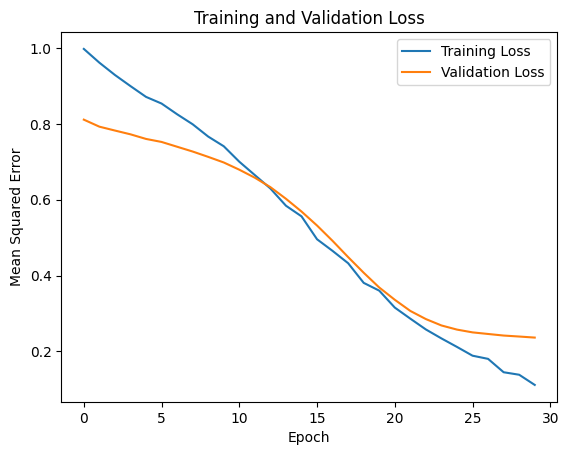

In [12]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [13]:
# run everytime before modelling
df_ts = df_num.copy()
df_ts.dtypes

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Features and target
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [14]:
def create_model():
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the batch sizes to test
param_grid = {'batch_size': [1, 2, 3, 4, 5, 6], 'epochs': [30]}

# Wrap the Keras model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Create a GridSearchCV instance with k-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3) # 3-fold cross-validation

# Fit the GridSearchCV instance to the data
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best result
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# Train the best model to save the history
best_model = create_model()
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=30,
                         batch_size=grid_result.best_params_['batch_size'],
                         validation_data=(X_test_scaled, y_test_scaled),
                         callbacks=[early_stopping])

Best: -0.7018798062020656 using {'batch_size': 3, 'epochs': 30}
Epoch 1/30
7/7 [==============================] - 1s 36ms/step - loss: 1.0034 - val_loss: 0.7579
Epoch 2/30
7/7 [==============================] - 0s 7ms/step - loss: 0.9235 - val_loss: 0.6972
Epoch 3/30
7/7 [==============================] - 0s 7ms/step - loss: 0.8658 - val_loss: 0.6439
Epoch 4/30
7/7 [==============================] - 0s 7ms/step - loss: 0.8056 - val_loss: 0.5968
Epoch 5/30
7/7 [==============================] - 0s 6ms/step - loss: 0.7437 - val_loss: 0.5434
Epoch 6/30
7/7 [==============================] - 0s 6ms/step - loss: 0.6726 - val_loss: 0.4791
Epoch 7/30
7/7 [==============================] - 0s 6ms/step - loss: 0.6024 - val_loss: 0.4234
Epoch 8/30
7/7 [==============================] - 0s 6ms/step - loss: 0.5157 - val_loss: 0.3700
Epoch 9/30
7/7 [==============================] - 0s 7ms/step - loss: 0.4530 - val_loss: 0.3321
Epoch 10/30
7/7 [==============================] - 0s 6ms/step - loss: 

In [15]:
# Prepare the last 3 data points for prediction
last_data_point = X[-3:].values
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])

# Make predictions using the best model
predicted_close_scaled = best_model.predict(last_data_point_scaled)

# Inverse transform the scaled predictions
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

# Print the predicted close prices
print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


1/1 [==============================] - 0s 137ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29334.13  29319.455 29410.81 ]


C:\Users\user\.conda\envs\spyder\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


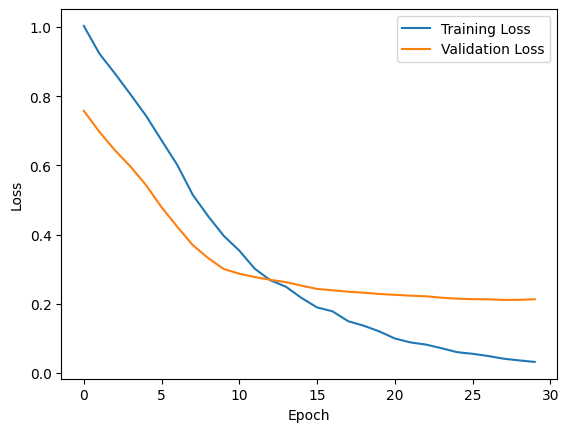

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
print(final_df.head(10))

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   
5 2023-07-19  29862.046875  30184.181641  29794.269531  29913.923828   
6 2023-07-20  29915.250000  30195.531250  29638.095703  29792.015625   
7 2023-07-21  29805.111328  30045.998047  29733.851563  29908.744141   
8 2023-07-22  29908.697266  29991.615234  29664.121094  29771.802734   
9 2023-07-23  29790.111328  30330.640625  29741.527344  30084.539063   

         Volume                                              title  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur... 

In [18]:
tdf = final_df.drop(columns=['content', 'description'])
print(tdf.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

         Volume                                              title  ABC News  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...         0   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur...         0   
2  2.091790e+10  A wave of political turbulence is rolling thro...         1   
3  1.324016e+10  US stocks rally as recession fears ease and in...         0   
4  1.313890e+10  Dow extends winning streak to 7 days as US sto...         0   

   Business Insider  CNN  Fox News  NBC News  New York Magazine  Newsweek  \
0        

In [19]:
# Create a sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [20]:
# Group by 'Date' and concatenate titles for each date
tdf1 = tdf.groupby('Date').agg({
    'Open': 'first',
    'High': 'first',
    'Low': 'first',
    'Close': 'first',
    'Volume': 'first',
    'title': ' '.join  # Concatenate titles
}).reset_index()

# Renaming the 'title' column to 'titles'
tdf1.rename(columns={'title': 'titles'}, inplace=True)


In [21]:
tdf1

,Date,Open,High,Low,Close,Volume,titles
0,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,1.480566e+10,US stocks climb as traders hope cooler June in...
1,2023-07-13,30387.488281,31814.515625,30268.351563,31476.048828,2.368608e+10,XRP soars 61% after a judge says the cryptocur...
2,2023-07-14,31474.720703,31582.253906,29966.386719,30334.068359,2.091790e+10,A wave of political turbulence is rolling thro...
3,2023-07-17,30249.626953,30336.400391,29685.783203,30145.888672,1.324016e+10,US stocks rally as recession fears ease and in...
4,2023-07-18,30147.070313,30233.656250,29556.427734,29856.562500,1.313890e+10,Dow extends winning streak to 7 days as US sto...
5,2023-07-19,29862.046875,30184.181641,29794.269531,29913.923828,1.212860e+10,Dow hits 8-day winning streak as investors hop...
6,2023-07-20,29915.250000,30195.531250,29638.095703,29792.015625,1.465521e+10,Dow notches 9-day win streak while earnings fr...
7,2023-07-21,29805.111328,30045.998047,29733.851563,29908.744141,1.097279e+10,A Nevada woman who hired a hitman using bitcoi...
8,2023-07-22,29908.697266,29991.615234,29664.121094,29771.802734,7.873301e+09,How to block those unwanted and annoying spam ...
9,2023-07-23,29790.111328,30330.640625,29741.527344,30084.539063,9.220145e+09,A bitcoin positive-feedback loop could more th...


In [22]:
def get_sentiment(text):
    result = sentiment_analyzer(text)[0]
    sentiment_score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return result['label'], sentiment_score

# Apply the function to the titles column
tdf1['sentiment'], tdf1['sentiment_score'] = zip(*tdf1['titles'].apply(get_sentiment))


In [23]:
print(tdf1.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

         Volume                                             titles sentiment  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  2.091790e+10  A wave of political turbulence is rolling thro...  NEGATIVE   
3  1.324016e+10  US stocks rally as recession fears ease and in...  NEGATIVE   
4  1.313890e+10  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  
0        -0.997129  
1        -0.947194  
2        -0.890904  
3 

In [24]:
col_names = tdf.columns.tolist()
col_names

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'title',
 'ABC News',
 'Business Insider',
 'CNN',
 'Fox News',
 'NBC News',
 'New York Magazine',
 'Newsweek',
 'Reuters',
 'The Washington Post',
 'Time',
 'USA Today',
 'Wired']

In [25]:
headlines_onehot = tdf[[ 'ABC News','Business Insider','CNN','Fox News','NBC News','New York Magazine','Newsweek','Reuters','The Washington Post',
 'Time','USA Today','Wired', 'Date']].copy()

In [26]:
tdf2 = tdf1.merge(headlines_onehot, on='Date', how='left')

tdf2.head(10)

,Date,Open,High,Low,Close,Volume,titles,sentiment,sentiment_score,ABC News,Business Insider,CNN,Fox News,NBC News,New York Magazine,Newsweek,Reuters,The Washington Post,Time,USA Today,Wired
0,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,1.480566e+10,US stocks climb as traders hope cooler June in...,NEGATIVE,-0.997129,0,3,0,1,0,0,0,0,0,0,0,0
1,2023-07-13,30387.488281,31814.515625,30268.351563,31476.048828,2.368608e+10,XRP soars 61% after a judge says the cryptocur...,NEGATIVE,-0.947194,0,2,0,0,0,0,0,0,0,0,0,0
2,2023-07-14,31474.720703,31582.253906,29966.386719,30334.068359,2.091790e+10,A wave of political turbulence is rolling thro...,NEGATIVE,-0.890904,1,1,1,1,0,0,0,0,0,0,0,1
3,2023-07-17,30249.626953,30336.400391,29685.783203,30145.888672,1.324016e+10,US stocks rally as recession fears ease and in...,NEGATIVE,-0.997980,0,3,0,0,0,0,0,0,0,0,0,0
4,2023-07-18,30147.070313,30233.656250,29556.427734,29856.562500,1.313890e+10,Dow extends winning streak to 7 days as US sto...,NEGATIVE,-0.779019,0,2,0,0,0,0,0,0,0,0,0,0
5,2023-07-19,29862.046875,30184.181641,29794.269531,29913.923828,1.212860e+10,Dow hits 8-day winning streak as investors hop...,POSITIVE,0.996341,0,1,0,0,0,0,0,1,0,0,0,0
6,2023-07-20,29915.250000,30195.531250,29638.095703,29792.015625,1.465521e+10,Dow notches 9-day win streak while earnings fr...,NEGATIVE,-0.996604,0,2,0,0,0,0,0,1,0,1,0,0
7,2023-07-21,29805.111328,30045.998047,29733.851563,29908.744141,1.097279e+10,A Nevada woman who hired a hitman using bitcoi...,NEGATIVE,-0.999121,3,3,0,0,0,0,0,0,0,0,2,0
8,2023-07-22,29908.697266,29991.615234,29664.121094,29771.802734,7.873301e+09,How to block those unwanted and annoying spam ...,NEGATIVE,-0.976153,0,1,0,1,0,0,0,0,0,0,0,0
9,2023-07-23,29790.111328,30330.640625,29741.527344,30084.539063,9.220145e+09,A bitcoin positive-feedback loop could more th...,NEGATIVE,-0.991503,0,1,0,0,0,0,0,0,0,0,0,0


In [27]:
print(tdf2.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

         Volume                                             titles sentiment  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  2.091790e+10  A wave of political turbulence is rolling thro...  NEGATIVE   
3  1.324016e+10  US stocks rally as recession fears ease and in...  NEGATIVE   
4  1.313890e+10  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  ABC News  Business Insider  CNN  Fox News  NBC News  \
0        -0

In [28]:
print(tdf2.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

         Volume                                             titles sentiment  \
0  1.480566e+10  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  2.368608e+10  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  2.091790e+10  A wave of political turbulence is rolling thro...  NEGATIVE   
3  1.324016e+10  US stocks rally as recession fears ease and in...  NEGATIVE   
4  1.313890e+10  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  ABC News  Business Insider  CNN  Fox News  NBC News  \
0        -0

In [29]:
# Assuming tdf2 is your new DataFrame with all the required columns
df_ts = tdf2.copy()

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Convert sentiment to categorical variable
le = LabelEncoder()
df_ts['sentiment'] = le.fit_transform(df_ts['sentiment'])
sentiment_onehot = to_categorical(df_ts['sentiment'])

# Concatenate sentiment one-hot encoding to the rest of the features
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume', 'sentiment','titles'], axis=1).values
X = np.hstack((X, sentiment_onehot))

# Target
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ... continue with the model creation, training, and evaluation as before


In [34]:
def create_model():
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the batch sizes to test
param_grid = {'batch_size': [1, 2, 3, 4, 5, 6], 'epochs': [15]}

# Wrap the Keras model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Create a GridSearchCV instance with k-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3) # 3-fold cross-validation

# Fit the GridSearchCV instance to the data
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best result
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

# Train the best model to save the history
best_model = create_model()
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=15,
                         batch_size=grid_result.best_params_['batch_size'],
                         validation_data=(X_test_scaled, y_test_scaled),
                         callbacks=[early_stopping])

Best: -0.8348532685154789 using {'batch_size': 1, 'epochs': 15}
Epoch 1/15
19/19 [==============================] - 1s 12ms/step - loss: 1.0192 - val_loss: 0.7739
Epoch 2/15
19/19 [==============================] - 0s 3ms/step - loss: 0.9330 - val_loss: 0.7156
Epoch 3/15
19/19 [==============================] - 0s 3ms/step - loss: 0.8679 - val_loss: 0.7002
Epoch 4/15
19/19 [==============================] - 0s 3ms/step - loss: 0.7897 - val_loss: 0.6473
Epoch 5/15
19/19 [==============================] - 0s 3ms/step - loss: 0.7106 - val_loss: 0.6111
Epoch 6/15
19/19 [==============================] - 0s 3ms/step - loss: 0.5676 - val_loss: 0.5197
Epoch 7/15
19/19 [==============================] - 0s 3ms/step - loss: 0.4584 - val_loss: 0.3821
Epoch 8/15
19/19 [==============================] - 0s 3ms/step - loss: 0.3320 - val_loss: 0.2910
Epoch 9/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2659 - val_loss: 0.2388
Epoch 10/15
19/19 [==============================] - 

In [35]:
# Prepare the last 3 data points for prediction
last_data_point = X[-3:]
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])

# Make predictions using the best model
predicted_close_scaled = best_model.predict(last_data_point_scaled)

# Inverse transform the scaled predictions
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

# Print the predicted close prices
print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


1/1 [==============================] - 0s 140ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29378.352 29434.807 29451.445]


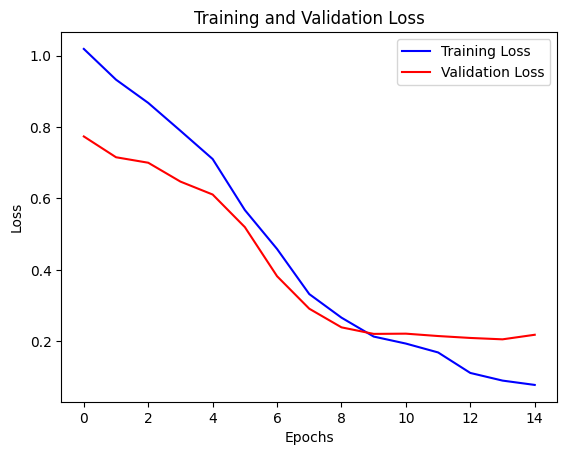

In [36]:
# Get the training loss values
training_loss = history.history['loss']

# Get the validation loss values
validation_loss = history.history['val_loss']

# Create a range for the x-axis (number of epochs)
epochs = range(len(training_loss))

# Plot the training loss
plt.plot(epochs, training_loss, 'b', label='Training Loss')

# Plot the validation loss
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()
